# Bounce clustering

### Why apply data clustering?

From a 2D video, only the vertical and horizontal movements of the ball can be extracted. However, in reality, the ball can also move towards or away from the camera. Observed from the camera, this can be perceived as a variation in altitude of the contact point between the ball and the ground.

Clustering the data would allow to associate to a given position and time the number of the bounce that the ball is currently making. Thus, the ground level can be adjusted by taking as local ground reference the minimum altitude within a cluster.

***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score as DBS

import OpenMORe.clustering as clustering

%matplotlib inline

## Creating the dataset

The data is extracted from a CSV file and processed.

In [2]:
data = pd.read_csv('ball_motion_data.csv', sep=',')
display(data) # t = time, x = horizontal position of the ball, y = height of the ball

,t,x,y
0,0.000000,92,192
1,0.041667,91,191
2,0.083333,91,192
3,0.125000,92,191
4,0.166667,92,190
...,...,...,...
105,4.375000,38,890
106,4.416667,38,891
107,4.458333,39,892
108,4.500000,39,892


In [3]:
n_data = data.shape[0] # number of samples (=110)

In [4]:
X = np.zeros((n_data,2))

# Extract only the time and the height of the ball
X[:,0] = np.array(data.iloc[:,0]) # time
X[:,1] = np.array(data.iloc[:,2]) # y-position = height of the ball

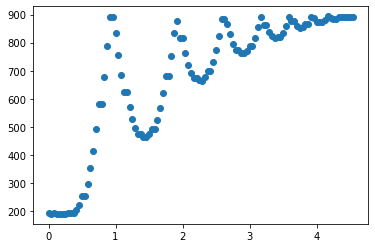

In [5]:
plt.scatter(X[:,0], X[:,1])
plt.show()

The data displayed on the ordinates ($y$-axis) in the previous graph correspond to the coordinates in the coordinate system of the video. To convert these values into ball heights, a transformation must be introduced.

In [6]:
X[:,1] = - X[:,1] + max(X[:,1])

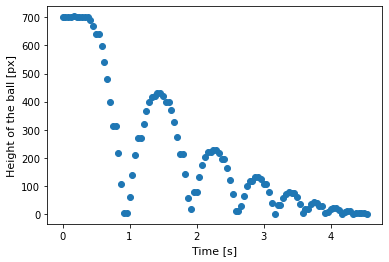

In [7]:
plt.scatter(X[:,0], X[:,1])
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Height of the ball [px]', fontsize=11)
plt.show()

***

## Clustering using K-Means

First, the dataset needs to be centered and scaled.

In [8]:
ci = np.mean(X, axis=0) # average w.r.t. each variable (= column) => 'axis=0'
di = np.std(X, axis=0)  # auto-standard scaling
X_std = (X - ci) / di

To automatically select the correct number of clusters, the Davies-Bouldin score (DBS) is used. It indicates how well the clustering has been performed. In fact, it represents the average "similarity" of clusters, where similarity is a measure that relates the distance of clusters to their size. A model with a lower DBS has a better separation between the clusters. Therefore, the optimal number of clusters is the one for which the DBS is minimal.

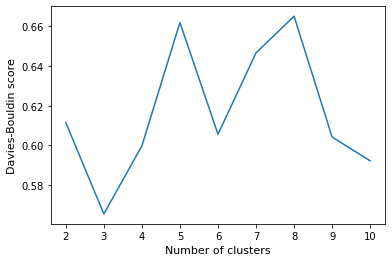

Optimal number of clusters = 3


In [9]:
# The number of clusters is selected in the interval [a,b].
a = 2
b = 10+1 # +1 because in Python, to go from a to b => [a,b+1[

# Initialization of vectors for storage
index = np.zeros(b-a)
dbs = np.zeros(b-a)

for k in range(a,b):
    
    index[k-a] = k # index[0] = 2, index[1] = 3, etc.
    
    # Use KMeans for clustering (with k clusters)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_std)
    labels = kmeans.labels_ # OR kmeans.predict(X_std)
    
    dbs[k-a] = DBS(X_std,labels) # compute the Davies-Bouldin score of the clustered dataset

# Plot the Davies-Bouldin score with respect to the number of clusters
plt.plot(index,dbs)
plt.xlabel('Number of clusters', fontsize=11)
plt.ylabel('Davies-Bouldin score', fontsize=11)
plt.show()

n_clusters = int(index[np.argmin(dbs)]) # int(): convert float to int ; argmin(dbs): index of the minimum value of dbs
print("Optimal number of clusters = " + str(n_clusters))

Clustering using K-Means can finally be performed.

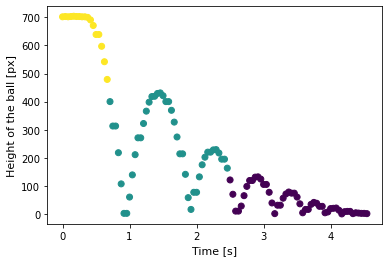

In [10]:
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X_std)
labels = kmeans.labels_ # OR kmeans.predict(X_std)

plt.scatter(X[:,0], X[:,1], c=labels)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Height of the ball [px]', fontsize=11)
plt.show()

K-Means minimizes the variances within the clusters (i.e. the squared Euclidean distances). It is very suitable for cloud data, but not in this case.

***

## Clustering using VQPCA

K-Means was not appropriate for this type of dataset. The VQPCA algorithm was also tested, but the goal of isolating each bounce was still not achieved.

In [11]:
# This is a dictionary used to set the VQPCA parameters.
clustering_settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #set the initialization method (random, observations, kmeans, pkcia, uniform)
    "initialization_method"     : "uniform",

    #set the number of clusters and PCs in each cluster
    "number_of_clusters"        : 5, # n_clusters
    "number_of_eigenvectors"    : 2, # = number of PCs = q

    #enable additional options:
    "correction_factor"         : "off",    # --> enable eventual corrective coefficients for the LPCA algorithm:
                                            #     'off', 'c_range', 'uncorrelation', 'local_variance', 'phc_multi', 'local_skewness' are available

    "classify"                  : False,    # --> call the method to classify a new matrix Y on the basis of the lpca clustering
    "write_on_txt"              : False,    # --> write the idx vector containing the label for each observation
    "evaluate_clustering"       : False,    # --> enable the calculation of indeces to evaluate the goodness of the clustering

    #improve the clustering solution via kNN
    "kNN_post"                  : False,     # activate the kNN algorithm once the convergence is achieved
    "neighbors_number"          : 2,        # set the number of neighbors that has to be taken into account
}

	It will be automatically set equal to: X.shape[1]-1.
	You can ignore this warning if the number of PCs has been assigned later via setter.
	Otherwise, please check the conditions which must be satisfied by the input in the detailed documentation.
Preprocessing training matrix..
Fitting Local PCA model...
- Iteration number: 1
	Reconstruction error: 0.011810793706063919
	Reconstruction error variance: 83.6683148387037
- Iteration number: 2
	Reconstruction error: 0.006983212482622397
	Reconstruction error variance: 0.6913123774272762
- Iteration number: 3
	Reconstruction error: 0.0061328687328927245
	Reconstruction error variance: 0.13865350568633242
- Iteration number: 4
	Reconstruction error: 0.00578866496223359
	Reconstruction error variance: 0.05946168467250876
- Iteration number: 5
	Reconstruction error: 0.00557210435347961
	Reconstruction error variance: 0.03886513873681215
- Iteration number: 6
	Reconstruction error: 0.005554781410554508
	Reconstruction error variance: 0.00311856

C:\Users\kiwix\DDE\project\DH\BounceClustering\OpenMORe\clustering.py:145: UserWarning: An exception occured with regard to the input value for the number of PCs. It could be not acceptable, or not given to the dictionary.
  warnings.warn("An exception occured with regard to the input value for the number of PCs. It could be not acceptable, or not given to the dictionary.")


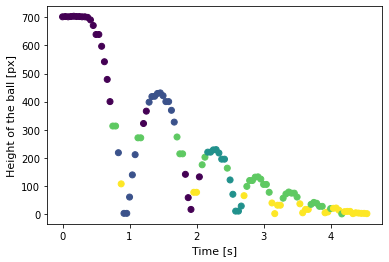

In [12]:
vqpca = clustering.lpca(X, clustering_settings)
labels_vqpca = vqpca.fit()

plt.scatter(X[:,0], X[:,1], c=labels_vqpca)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Height of the ball [px]', fontsize=11)
plt.show()

***

## K-Means clustering only on the time

Clustering on the time and ball height using K-Means does not yield the expected results. Therefore, we tried several intuitive clustering methods. One of them is to apply clustering only on the time variable.

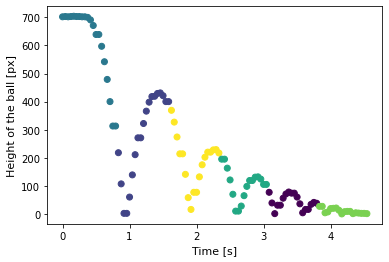

In [13]:
T = np.zeros((n_data,1))
T[:,0] = np.array(data.iloc[:,0]) # time

kmeans_T = KMeans(n_clusters=6)
kmeans_T.fit(T)
labels_T = kmeans_T.labels_

plt.scatter(X[:,0], X[:,1], c=labels_T)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Height of the ball [px]', fontsize=11)
plt.show()

To increase the importance of the time, a clustering on the time squared was performed. This allows the $x$-distances between the points to be accentuated (increasing the larger gaps and reducing the smaller ones) when applying K-Means.

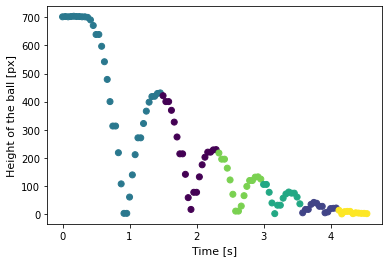

In [14]:
TT = T**2 # time squared

kmeans_TT = KMeans(n_clusters=6)
kmeans_TT.fit(TT)
labels_TT = kmeans_TT.labels_

plt.scatter(X[:,0], X[:,1], c=labels_TT)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Height of the ball [px]', fontsize=11)
plt.show()

The results obtained are much closer to the expected results and can be exploited to cluster each bounce.

***

## K-Means clustering on the cumulative height

Previously, we have seen that K-Means tends to put in the same cluster the data that have the same ball height. To overcome this problem, a cluster based on cumulative heights has been performed. This allows to have only one or a few locally identical ordinate values over the whole period of the experiment.

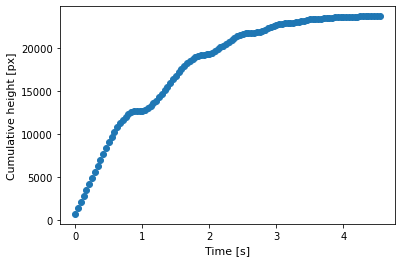

In [15]:
# Initialization
h_cumul = 0
H_vec = np.array([])

# Compute the cumulative height
for i in range(n_data):
    h_cumul += X[i,1]
    H_vec = np.append(H_vec, h_cumul)

plt.scatter(X[:,0], H_vec)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Cumulative height [px]', fontsize=11)
plt.show()

In [16]:
H = np.zeros((n_data,2))
H[:,0] = np.array(data.iloc[:,0]) # time
H[:,1] = H_vec # cumulative height

# Center and scale the data
ci = np.mean(H, axis=0) # average w.r.t. each variable (= column) => 'axis=0'
di = np.std(H, axis=0)  # auto-standard scaling
H_std = (H - ci) / di

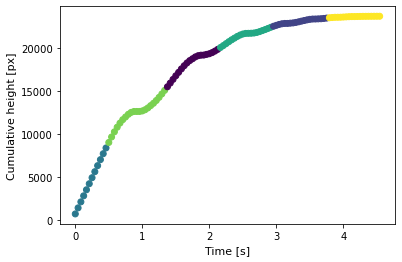

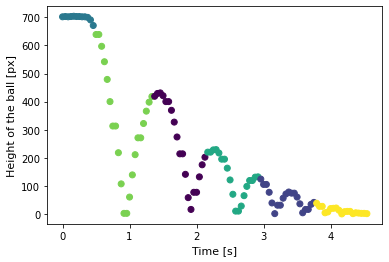

In [17]:
kmeans_H = KMeans(n_clusters=6)
kmeans_H.fit(H_std)
labels_H = kmeans_H.labels_

plt.scatter(X[:,0], H_vec, c=labels_H)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Cumulative height [px]', fontsize=11)
plt.show()

plt.scatter(X[:,0], X[:,1], c=labels_H)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Height of the ball [px]', fontsize=11)
plt.show()

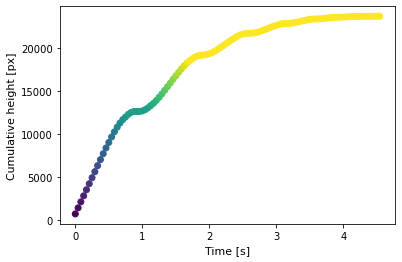

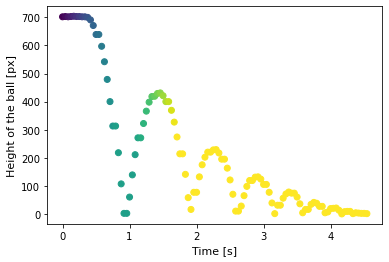

Number of clusters = 35


In [18]:
dbscan = DBSCAN(eps=0.05, min_samples=1)
dbscan.fit(H_std)
labels_dbscan = dbscan.labels_

plt.scatter(X[:,0], H_vec, c=labels_dbscan)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Cumulative height [px]', fontsize=11)
plt.show()

plt.scatter(X[:,0], X[:,1], c=labels_dbscan)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Height of the ball [px]', fontsize=11)
plt.show()

print("Number of clusters = " + str(max(labels_dbscan)+1))

	It will be automatically set equal to: X.shape[1]-1.
	You can ignore this warning if the number of PCs has been assigned later via setter.
	Otherwise, please check the conditions which must be satisfied by the input in the detailed documentation.
Preprocessing training matrix..
Fitting Local PCA model...
- Iteration number: 1
	Reconstruction error: 0.0035475394214737723
	Reconstruction error variance: 280.88552153835263
- Iteration number: 2
	Reconstruction error: 0.002363551642712073
	Reconstruction error variance: 0.500935861677693
- Iteration number: 3
	Reconstruction error: 0.002278132989045827
	Reconstruction error variance: 0.03749502512670365
- Iteration number: 4
	Reconstruction error: 0.0022400568841652677
	Reconstruction error variance: 0.016997829452330037
- Iteration number: 5
	Reconstruction error: 0.002145854139679979
	Reconstruction error variance: 0.04389988244929707
- Iteration number: 6
	Reconstruction error: 0.0019846320495683074
	Reconstruction error variance: 0.08

C:\Users\kiwix\DDE\project\DH\BounceClustering\OpenMORe\clustering.py:145: UserWarning: An exception occured with regard to the input value for the number of PCs. It could be not acceptable, or not given to the dictionary.
  warnings.warn("An exception occured with regard to the input value for the number of PCs. It could be not acceptable, or not given to the dictionary.")


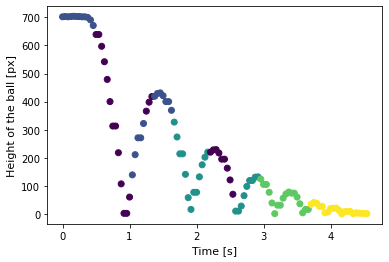

In [19]:
vqpca = clustering.lpca(H_std, clustering_settings)
labels_vqpca = vqpca.fit()

plt.scatter(X[:,0], X[:,1], c=labels_vqpca)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Height of the ball [px]', fontsize=11)
plt.show()

***

## K-Means clustering on the velocity

Since the velocity of the ball is a linear function, one would think that velocity-based clustering would be easier.

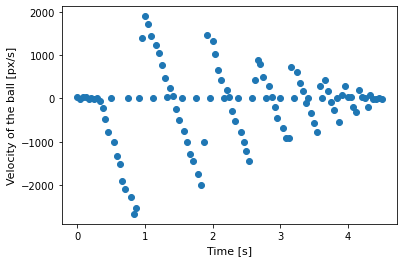

In [20]:
t = X[:,0]
y = X[:,1]

# Compute the ball vertical velocity
V_vec = np.array([])
for i in range(n_data-1):
    dy = ( y[i+1] - y[i] ) / ( t[i+1] - t[i] )
    V_vec = np.append(V_vec, dy)

plt.scatter(t[0:-1], V_vec)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Velocity of the ball [px/s]', fontsize=11)
plt.show()

In [21]:
V = np.zeros((n_data-1,2))
V[:,0] = t[0:-1] # time
V[:,1] = V_vec # velocity

# Center and scale the data
ci = np.mean(V, axis=0) # average w.r.t. each variable (= column) => 'axis=0'
di = np.std(V, axis=0)  # auto-standard scaling
V_std = (V - ci) / di

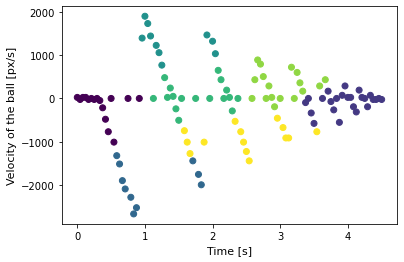

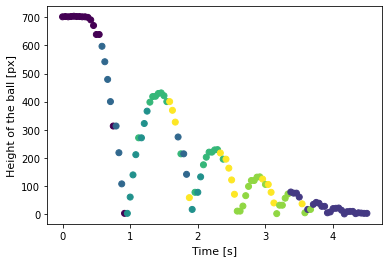

In [22]:
kmeans_V = KMeans(n_clusters=7)
kmeans_V.fit(V_std)
labels_V = kmeans_V.labels_

plt.scatter(t[0:-1], V_vec, c=labels_V)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Velocity of the ball [px/s]', fontsize=11)
plt.show()

plt.scatter(t[0:-1], y[0:-1], c=labels_V)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Height of the ball [px]', fontsize=11)
plt.show()

***

## Clustering using DBSCAN

#### Sources
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556
- https://en.wikipedia.org/wiki/DBSCAN

DBSCAN is another clustering method. It stands for "Density-Based Spatial Clustering of Applications with Noise" and is able to find arbitrary shaped clusters and clusters with noise (i.e. outliers). The main idea behind DBSCAN is that a point belongs to a cluster if it is close to many points from that cluster.

There are two key parameters of DBSCAN:
- eps: The distance that specifies the neighborhoods. Two points are considered to be neighbors if the distance between them are less than or equal to eps.
- min_samples: Minimum number of data points to define a cluster.

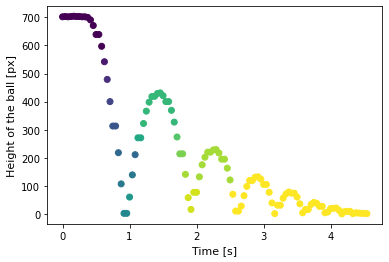

Number of clusters = 16


In [23]:
dbscan = DBSCAN(eps=0.2, min_samples=1)
dbscan.fit(X_std)
labels_dbscan = dbscan.labels_

plt.scatter(X[:,0], X[:,1], c=labels_dbscan)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Height of the ball [px]', fontsize=11)
plt.show()

print("Number of clusters = " + str(max(labels_dbscan)+1))

The clusters obtained with DBSCAN using both time and ball height are close to what we wanted. However, the number of clusters is too large and some contain only one or very few points. An algorithm can be written to distribute these small clusters into the larger ones, but this would distort the automatic aspect of the DBSCAN algorithm.